In [1]:
library(Seurat)
library(ggplot2)
library(dplyr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [3]:
adrenal_whole = new.env()
adrenal_whole$SR = readRDS('../data/Seurat/adrenal.human.seurat.rds')

adrenal_medulla = new.env()
adrenal_medulla$SR = adrenal_whole$SR[,adrenal_whole$SR@meta.data$fate == 'medulla']

rm(adrenal_whole)
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,2012556,107.5,4005470,214.0,2482547,132.6
Vcells,56451265,430.7,922291212,7036.6,773035692,5897.8


PC_ 1 
Positive:  STMN2, PHOX2A, DBH, PCSK1N, CHGB, RGS5, GAP43, ELAVL4, STMN4, PHOX2B 
	   GAL, VSTM2L, EML5, EEF1A2, LINC00682, SCG2, ISL1, TUBB2B, RTN1, HAND2-AS1 
	   CNTN1, CHGA, RGS4, GNG3, TH, CHRNA3, NSG2, SCG3, TAGLN3, TFAP2B 
Negative:  SELENOP, MT2A, APOE, FN1, HES1, MGST2, GNG11, SH3BP5, SAT1, RARRES2 
	   SLC9A3R2, PLPP3, BLVRB, SLC25A37, IGFBP7, COL4A1, S100A10, IGFBP5, MGST1, SPRY1 
	   APOA1, GMFG, TM4SF1, RGCC, PLVAP, CAVIN2, EMCN, TPM2, CD36, GPC3 
PC_ 2 
Positive:  RTN1, PRPH, GAP43, STMN4, ARHGDIG, ELAVL2, SLC6A2, RBFOX1, TTC9B, NEFL 
	   MAPT, MAOA, PLXNA4, NPY, ISL1, TUBB2B, GAL, ELAVL4, MLLT11, SHOX2 
	   TUBB2A, SYNPO2, PRSS3, HMX1, SV2C, CALB2, NEFM, TMSB15A, BASP1, INA 
Negative:  S100B, PLP1, CDH19, MPZ, PTPRZ1, ERBB3, SOX10, METRN, INSM1, PENK 
	   FOXD3, TRPM3, OLFML2A, SLITRK2, NRXN1, MOXD1, CARTPT, TTYH1, SLC24A2, C1QL1 
	   ST18, FOXD3-AS1, CDH6, SCRG1, PNMT, CHGA, VWA5B2, PCSK2, SERTM2, SOX2 
PC_ 3 
Positive:  PENK, INSM1, CARTPT, SLC24A2, CHGA, PNMT, S

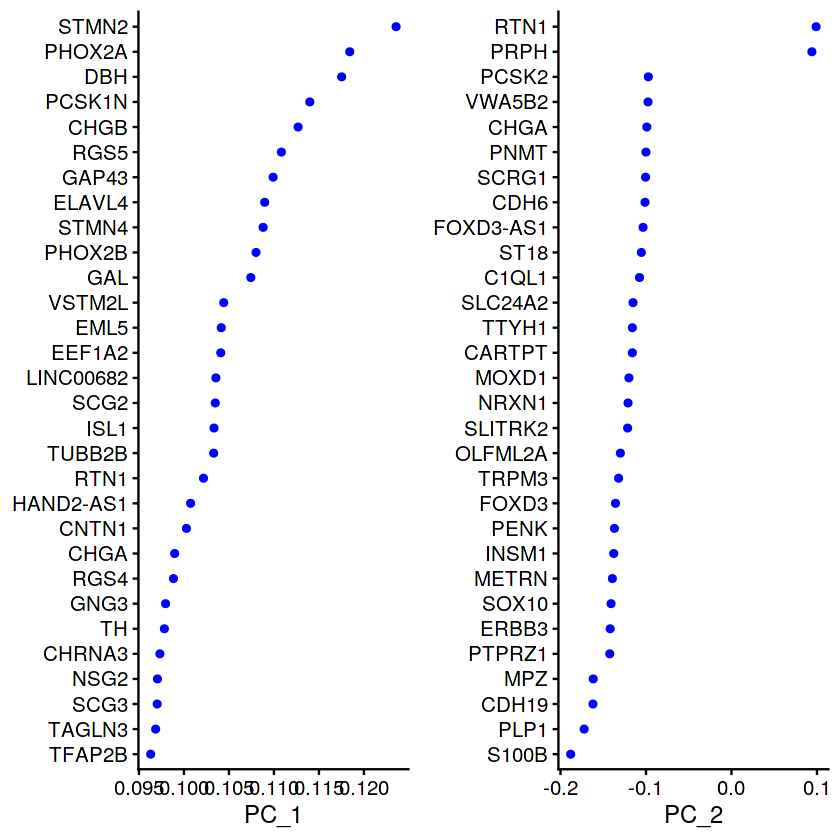

Computing nearest neighbor graph
Computing SNN


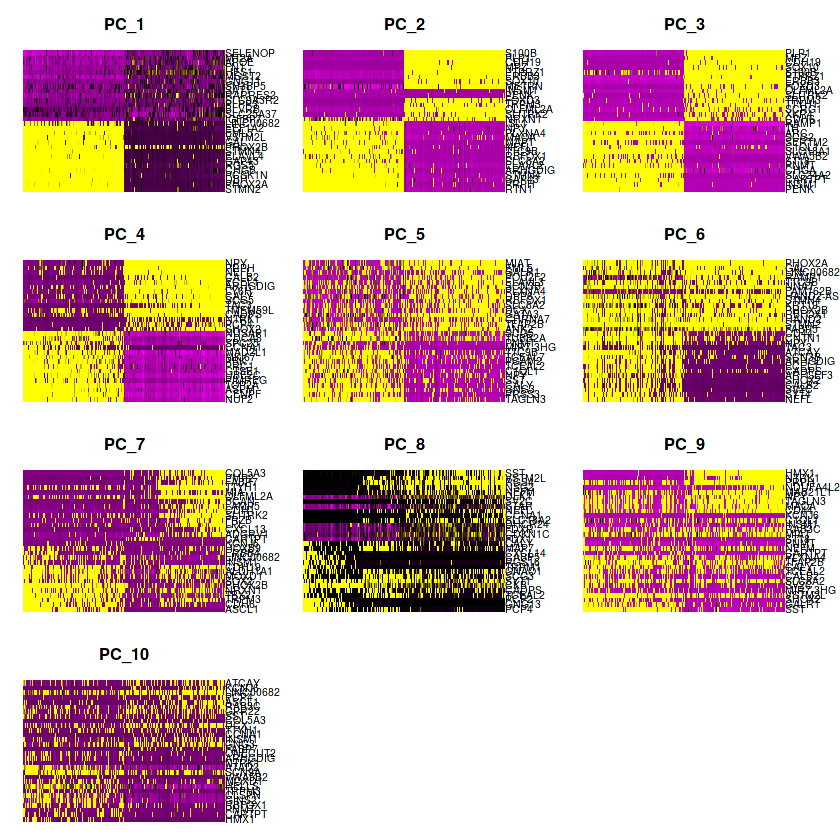

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 5238
Number of edges: 113976

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9726
Number of communities: 9
Elapsed time: 0 seconds


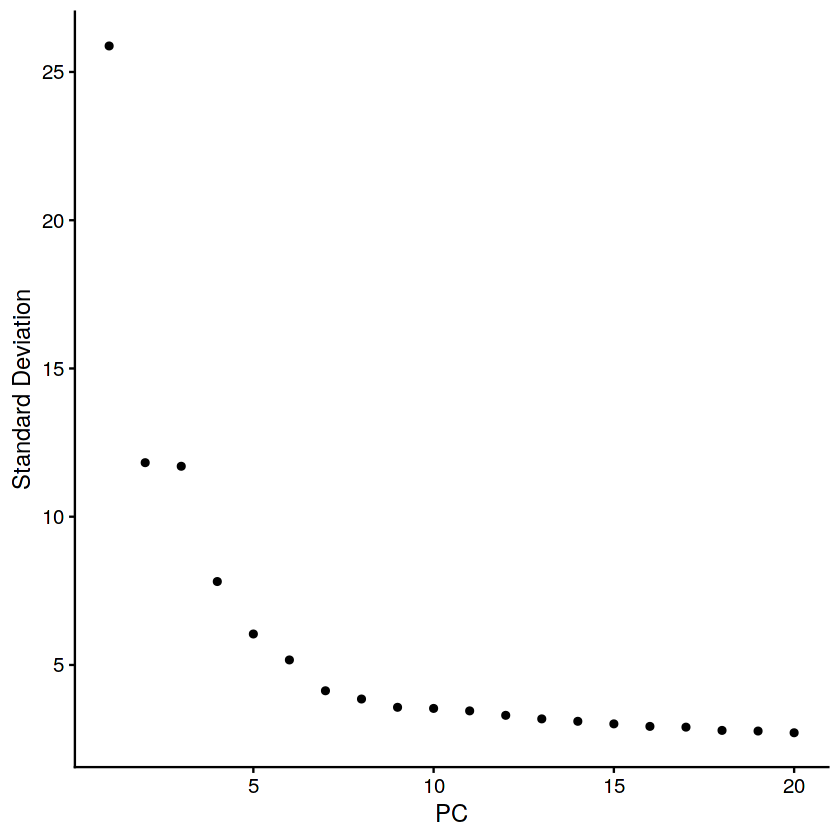

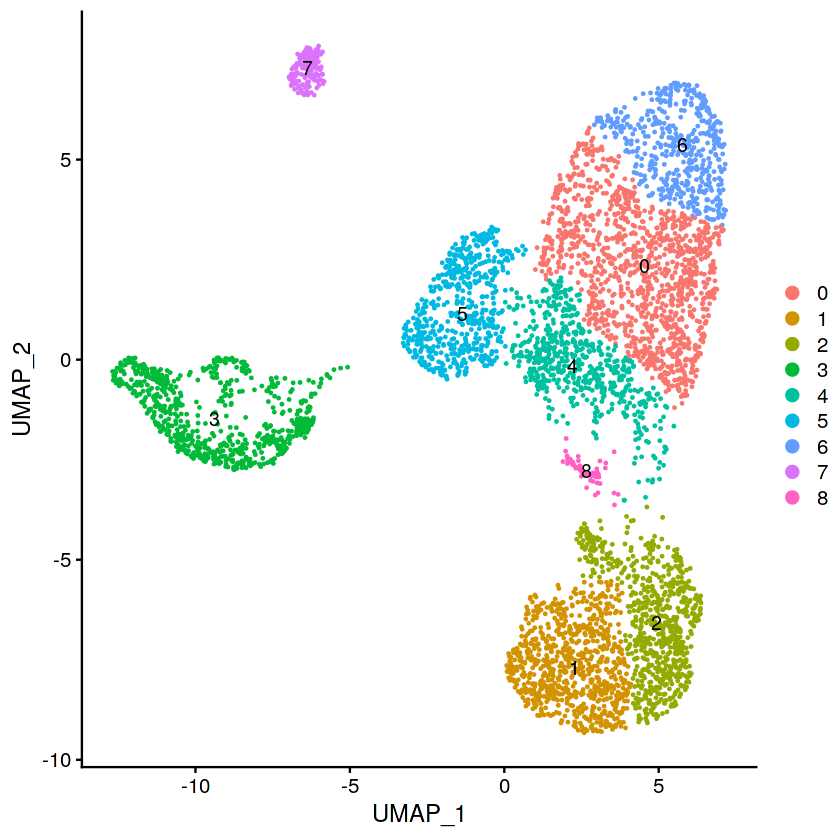

In [8]:
with(adrenal_medulla, {

    SR <- RunPCA(SR, features = VariableFeatures(object = SR))
    print(SR[["pca"]], dims = 1:5, nfeatures = 5)
    plot(VizDimLoadings(SR, dims = 1:2, reduction = "pca"))

    DimHeatmap(SR, dims = 1:10, cells = 500, balanced = TRUE)

    SR <- JackStraw(SR, num.replicate = 100)
    SR <- ScoreJackStraw(SR, dims = 1:20)

    plot(ElbowPlot(SR))

    #SR <- FindNeighbors(SR, dims = 1:5)
    #SR <- FindClusters(SR, resolution = 0.5)
    SR <- FindNeighbors(SR, reduction = "umap", dims=1:2)
    SR <- FindClusters(SR, resolution = 0.1)

    SR <- RunUMAP(SR, dims = 1:8)
    plot(DimPlot(SR, reduction = "umap", label=T))
})

In [9]:
adrenal_medulla$SR = adrenal_medulla$SR[,adrenal_medulla$SR@meta.data$seurat_clusters!=7]

DimPlot(adrenal_medulla$SR, reduction = "umap", label=T)

Computing nearest neighbor graph
Computing SNN


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 5090
Number of edges: 110880

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9713
Number of communities: 7
Elapsed time: 0 seconds


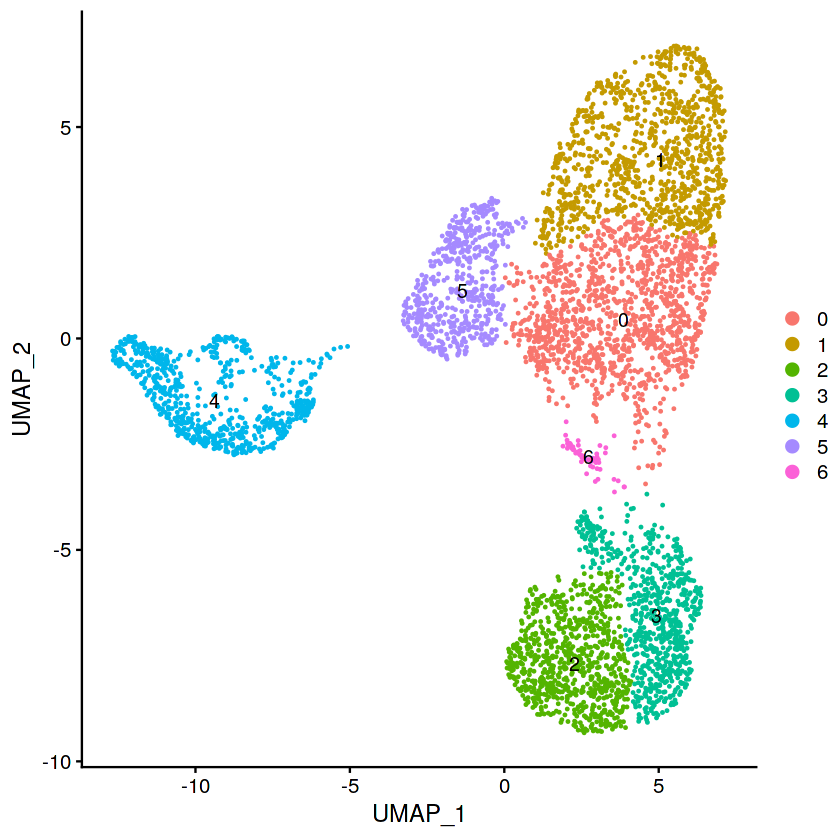

In [11]:
with(adrenal_medulla, {
    SR <- FindNeighbors(SR, reduction = "umap", dims=1:2)
    SR <- FindClusters(SR, resolution = 0.1)
    DimPlot(SR, reduction = "umap", label=T)
})

## Load pre-processed data

In [12]:
adrenal_medulla = readRDS('../data/Seurat/adrenal_medulla.rds')

In [ ]:
l_cluster_annotation = list(2,
                            4,
                            c(0,3,5),
                            1
                           )
names(l_cluster_annotation) = c('SCP', 'cycling', 'sympathoblasts', 'chromaffin')

adrenal_medulla$SR@meta.data$fate = 'other'

for(i in 1:length(l_cluster_annotation)){
    adrenal_medulla$SR@meta.data$fate[adrenal_medulla$SR@meta.data$seurat_clusters %in% l_cluster_annotation[[i]] ] = names(l_cluster_annotation)[i]
}


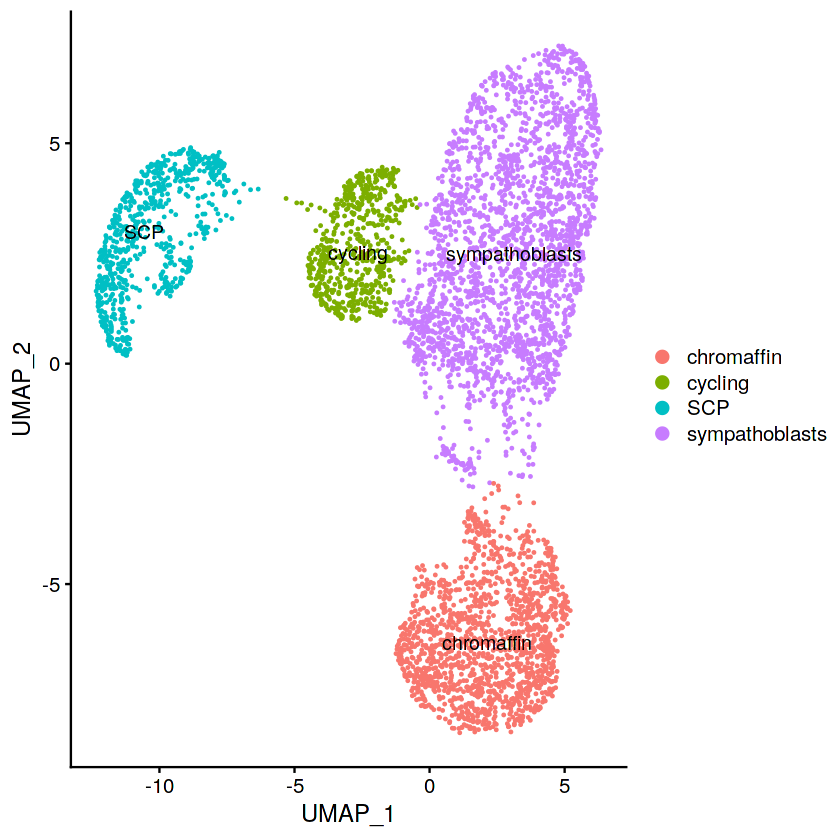

In [15]:
DimPlot(adrenal_medulla$SR, reduction = "umap", group.by='fate', label=T)

# Dotplot: fate markers

In [ ]:
with(adrenal_medulla, {
    Idents(SR) ='fate'
    
    SR.markers.AUC.fate <- FindAllMarkers(SR, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25,
                                    test='roc'
                                   )
    library(dplyr)
    top10.AUC.fate <- SR.markers.AUC.fate %>% group_by(cluster) %>% top_n(n = 5, wt = myAUC)
})

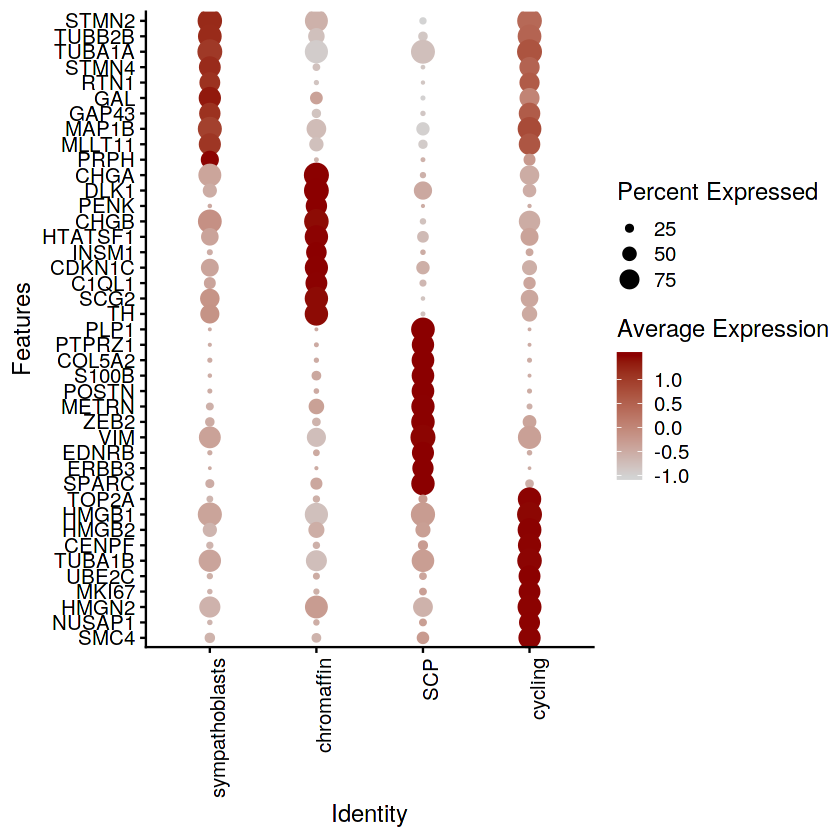

In [13]:
DotPlot(adrenal_medulla$SR, features = unique(adrenal_medulla$top10.AUC.fate$gene), cols = c("lightgrey", "darkred"))+
         coord_flip()+theme(axis.text.x = element_text(angle = 90, hjust = 1))
#ggsave('dotplot_cluster.medulla.fate.top5AUC.pdf', width=7,height=12)

In [14]:
# export UMAP embedding as csv for velocity plots
write.csv(adrenal_medulla$SR@reductions$umap@cell.embeddings, 
          file='../data/embeddings/adrenal_medulla.UMAP.csv')

# Trajectories and transitions between cell fates

In [18]:
source('../src/bridge_heatmap.R')
cds = seurat2monocle(adrenal_medulla$SR, fix_partitions=T)

  |======================================================================| 100%


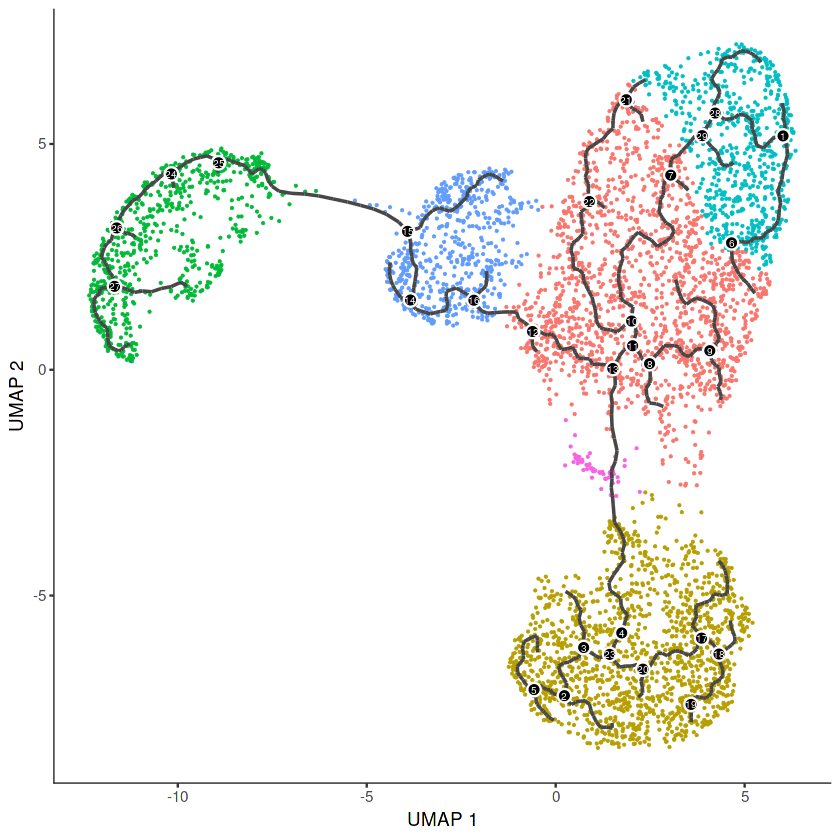

In [19]:
plot_cells(cds,
           color_cells_by = "seurat_cluster",
           label_groups_by_cluster=FALSE,
           label_leaves=FALSE,
           label_branch_points=T,
          cell_size = 0.5,
          label_cell_groups=F)+NoLegend()

## SCPs to sympathoblasts

Warning message in subgraph(cds@principal_graph$UMAP, all_simple_paths(cds@principal_graph$UMAP, :
“At structural_properties.c:1945 :igraph_subgraph is deprecated from igraph 0.6, use igraph_induced_subgraph instead”

[1] "figures/tmp.trajectory.pdf"


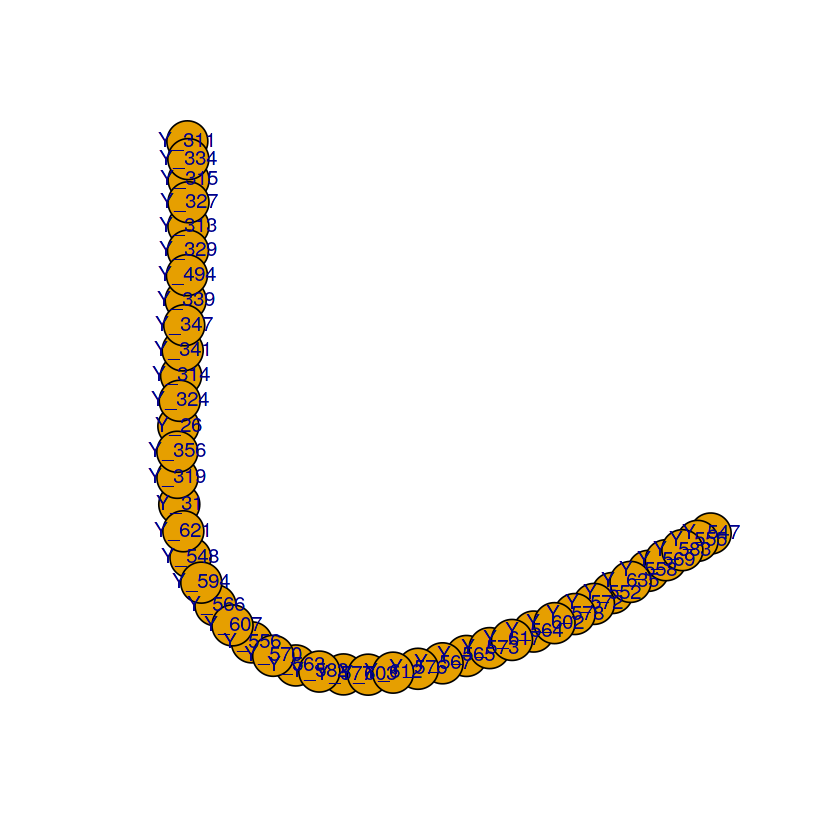

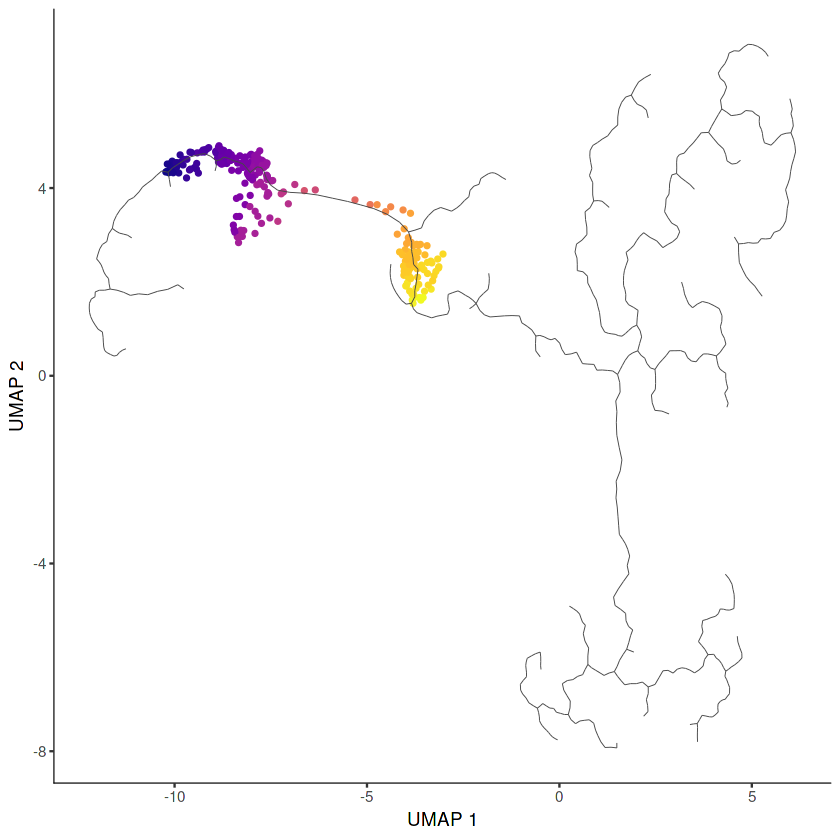

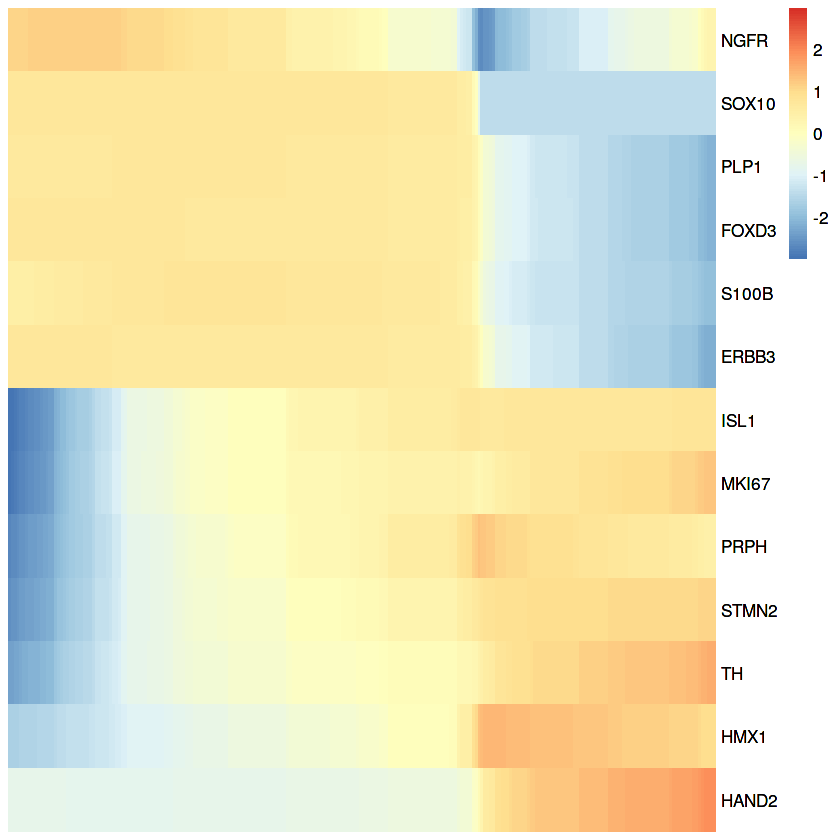

In [22]:
pr_deg_ids = c('NGFR', 'SOX10', 'PLP1', 'FOXD3', 'S100B',  'ERBB3', 'ISL1', 'MKI67', 'PRPH', 'STMN2', 'TH', 'HMX1', 'HAND2')
analyze_bridge(cds, 24, 14, pr_deg_ids, f_heatmap = 'figures/tmp.heatmap.pdf')

## sympathoblasts to chromaffin

In [ ]:
pr_deg_ids = toupper(c(
    'Stmn2','Isl1','Hand2','Prph','Hmx1','Pnmt','Chga','Penk', 'Th'
))
analyze_bridge(cds, 13, 4, pr_deg_ids, f_heatmap = 'figures/tmp.heatmap.pdf')

# Survival plots

### Survival plots for signatures of each cell fate

In [ ]:
genes_cell_cycle = toupper(read.csv('../data/cell_cycle_genes.csv')$gene)

In [ ]:
dat=readRDS('../data/bulk_survival/GSE49711.dat.rds')

exp=dat$dat
ano=dat$ano

ano$time=as.numeric(ano$OS)
ano$vital_status=ano$OS.event
ano$inss=ano$inss.stage

index=ano$inss!='4S'
ano=ano[index,]
exp=exp[,index]

In [ ]:
source('../src/survival_bootstrap.R')
#dir.create('figures/figS2_survival/')
#dir.create('figures/figS2_survival/major_fates/')
genes_by_fate = list()
for(fate in unique(adrenal_medulla$SR.markers.AUC$cluster)){
    print(fate)
    genes_cluster = rownames(adrenal_medulla$SR.markers.AUC[adrenal_medulla$SR.markers.AUC$cluster==fate,])
    genes_by_fate[[fate]] = setdiff(genes_cluster, genes_cell_cycle)
    
    ano[[paste0('fate_', fate)]] = as.vector(colSums(exp[rownames(exp) %in% genes_by_fate[[fate]],]))#as.vector(colSums(exp[rownames(exp) %in% genes_cluster,]))
    #hist(ano[[paste0('fate_', fate)]], main=length(genes_by_fate[[fate]]))
}

fit=NULL
p0 = NULL
for(fate in unique(adrenal_medulla$SR.markers.AUC$cluster)){
    print(fate)
    p = surv(paste0('fate_', fate), mycn=0)
    #ggsave(paste0('figures/figS2_survival/survival.',gene,'.pdf'), print(p[[2]]))
    #ggsave(paste0('figures/figS2_survival/survival_fate.mycn0.',fate,'.pdf'), p$plot, width=5, height=5)
    #ggsave(paste0('figures/figS2_survival/major_fates/survival_fate.mycn0.noCC.',fate,'.pdf'), p$plot, width=5, height=5)
    print(p)
    p = surv(paste0('fate_', fate), mycn=1)
    print(p)
    #ggsave(paste0('figures/figS2_survival/major_fates/survival_fate.mycn1.noCC.',fate,'.pdf'), p$plot, width=5, height=5)
}

### Survival plots for signatures: bootstrap analysis

In [ ]:
dir.create('figures/figS2_survival/')
dir.create('figures/figS2_survival/bootstrap/')

genes_by_fate = list()


for(fate in unique(adrenal_medulla$SR.markers.AUC$cluster)){
    print(fate)
    genes_cluster = rownames(adrenal_medulla$SR.markers.AUC[adrenal_medulla$SR.markers.AUC$cluster==fate,])
    genes_by_fate[[fate]] = setdiff(genes_cluster, genes_cell_cycle)
    
    ano[[paste0('fate_', fate)]] = as.vector(colSums(exp[rownames(exp) %in% genes_by_fate[[fate]],]))#as.vector(colSums(exp[rownames(exp) %in% genes_cluster,]))
    #hist(ano[[paste0('fate_', fate)]], main=length(genes_by_fate[[fate]]))
}

for(mycn in c(0,1)){
    lres = surv_bootstrap(genes_by_fate, exp, ano, Nbootstrap=100, mycn=mycn)
    
    for(fate in names(genes_by_fate)){
        
        p = ggplot(lres[[fate]], aes(time, surv, col=x))+
        geom_step(aes(group = paste(x, iteration), 
                      alpha=ifelse(set=='bootstrap', 0.8,1)))+
        theme_bw()+theme(legend.position = "none")+ylab('Survival probability')+xlab('Time')
        print(p)

        ggsave(paste0('figures/figS2_survival/bootstrap/survival_fate.mycn',mycn,'.noCC.',fate,'.pdf'), p, width=5, height=5)
        #plot(p)
        #p = surv(paste0('fate_', fate), mycn=1)
        #ggsave(paste0('figures/figS2_survival/survival_fate.mycn1.noCC.',fate,'.pdf'), p$plot, width=5, height=5)
    }
}

### Survival plots for individual genes (multipage pdf)

In [ ]:
library(cowplot)
dir.create('figures/figS2_survival/')
dir.create('figures/figS2_survival/export_noCC/')
fit=NULL
p0 = NULL
for(fate in unique(adrenal_medulla$SR.markers.AUC.fate$cluster)){
    
    #separate plos for tumors with and without MYCN amplification
    for(mycn in c(0,1)){
        plist = list()
        for(gene in genes_by_fate[[fate]]){
            p = surv(gene, mycn=mycn)

            if(!is.null(p)){
                p1 = p$plot+ggtitle(gene)
                plist[[gene]]=p1
            }
        }

        # Four pages of plots in one PDF file

        pdf(paste0('figures/figS2_survival/export_noCC/survival.',fate,'.mycn',mycn,'.allgenes.pdf'), width=8, height=10)
        for (i in seq(1, length(plist), 12)) {
          print(
              do.call(plot_grid, c(plist[i:(i+12-1)], ncol=3))
              )
        }


        dev.off()
    }
}

In [ ]:
DimPlot(adrenal_medulla$SR, group.by='fate', pt.size = 2)+NoLegend()
#ggsave('figures/fig2_medulla/007.adrenal_whole.fates.5x5pt2.png', width=5, height=5, dpi=320)